# What is L1 cache throughput for different access patterns?

The time to load data for a warp wide load instruction depends on the loaded addresses.

In [1]:
import pycuda.driver as drv
import pycuda
import pycuda.autoinit
import numpy
import random
import svgwrite
import matplotlib.pyplot as plt
from pycuda.compiler import SourceModule

from subprocess import run, PIPE


In [2]:
def printSASS(code):
    cubin = pycuda.compiler.compile(code, options=["-w", "-std=c++11"], arch="sm_70")

    run(["echo \"" + code + "\" >> temp.cubin"], stdout=PIPE, shell=True)

    newFile = open("temp.cusbin", "wb")
    newFile.write(cubin)
    newFile.close()

    result = run(["nvdisasm  temp.cusbin"], stdout=PIPE, shell=True)

    print(len(result.stdout.decode("utf-8").split("\n")))

    print(result.stdout.decode("utf-8"))

    newFile = open("temp.disasm", "wb")
    newFile.write(result.stdout)
    newFile.close()


In [5]:
cleaner_kernel = """__global__ void cleaner(double * buf, int N) {{
    double sum = 0.0;
    for(int idx = threadIdx.x; idx < N; idx += blockDim.x) {{
        sum += buf[idx];
    }}
    if( sum == 0.123123) buf[threadIdx.x] = sum;

}}"""

cleaner_mod = SourceModule(cleaner_kernel, arch="sm_70", options=["-lineinfo" "-O3" "-w" "-std=c++11"])
cleaner_function = cleaner_mod.get_function("cleaner")
cleaner_function.prepare(('P',numpy.int32))


In [64]:
kernel_template = """__global__ void kernel({0} * buf, {0} * buf2, int* addresses, int N, int zero) {{
    int warpLane = threadIdx.x % 32;
    int index =  (threadIdx.x / 32)*512 + addresses[warpLane];
    
    {0} sum = 0;
#pragma unroll(1)
    for( int iter = 0; iter < N; iter++) {{
        for( int i = 0; i < 8; i++) {{
            sum += buf[iter*zero + i*zero + index] *  buf2[iter*zero + i*zero + index];
        }}
    }}
    if( sum == 0.123123) buf[index] = sum;

}}"""

In [65]:
print(kernel_template.format("double"))

mod = SourceModule(kernel_template.format("double"), arch="sm_70", options=["-lineinfo" "-O3" "-w" "-std=c++11"])
function = mod.get_function("kernel")
function.prepare(('P', 'P', 'P', numpy.int32, numpy.int32))


__global__ void kernel(double * buf, double * buf2, int* addresses, int N, int zero) {
    int warpLane = threadIdx.x % 32;
    int index =  (threadIdx.x / 32)*512 + addresses[warpLane];
    
    double sum = 0;
#pragma unroll(1)
    for( int iter = 0; iter < N; iter++) {
        for( int i = 0; i < 8; i++) {
            sum += buf[iter*zero + i*zero + index] *  buf2[iter*zero + i*zero + index];
        }
    }
    if( sum == 0.123123) buf[index] = sum;

}


In [66]:
printSASS(kernel_template.format("double"))

299
	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM70 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM70)"
	.elftype	@"ET_EXEC"


//--------------------- .debug_frame              --------------------------
	.section	.debug_frame,"",@progbits
.debug_frame:
        /*0000*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff
        /*0010*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x03, 0x00, 0x04, 0x7c, 0xff, 0xff, 0xff, 0xff, 0x0f, 0x0c, 0x81, 0x80
        /*0020*/ 	.byte	0x80, 0x28, 0x00, 0x08, 0xff, 0x81, 0x80, 0x28, 0x08, 0x81, 0x80, 0x80, 0x28, 0x00, 0x00, 0x00
        /*0030*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0040*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0048*/ 	.dword	kernel
        /*0050*/ 	.byte	0x70, 0x05, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x02, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00
        /*0060*/ 	.byte	0x00, 0x00, 0x0

0 2  2.056 cyc
16 2  2.056 cyc
32 2  2.056 cyc
48 2  3.012 cyc
64 2  2.056 cyc
80 2  3.012 cyc
96 2  2.056 cyc
112 2  3.012 cyc
128 2  2.056 cyc
144 2  3.012 cyc
160 2  2.055 cyc
176 2  3.012 cyc
192 2  2.056 cyc
208 2  3.011 cyc
224 2  2.055 cyc
240 2  2.055 cyc
256 2  2.056 cyc
272 2  3.012 cyc
288 2  2.056 cyc
304 2  3.012 cyc
320 2  2.056 cyc
336 2  3.012 cyc
352 2  2.056 cyc
368 2  3.012 cyc
384 2  2.056 cyc
400 2  3.012 cyc
416 2  2.055 cyc
432 2  3.012 cyc
448 2  2.056 cyc
464 2  3.012 cyc
480 2  2.055 cyc
496 2  2.886 cyc
512 2  2.058 cyc
528 2  3.012 cyc
544 2  2.059 cyc
560 2  3.011 cyc
576 2  2.058 cyc
592 2  3.011 cyc
608 2  2.059 cyc
624 2  3.009 cyc
640 2  2.059 cyc
656 2  3.011 cyc
672 2  2.057 cyc
688 2  3.012 cyc
704 2  2.059 cyc
720 2  3.012 cyc
736 2  2.057 cyc
752 2  2.057 cyc
768 2  2.057 cyc
784 2  3.011 cyc
800 2  2.059 cyc
816 2  3.012 cyc
832 2  2.058 cyc
848 2  3.012 cyc
864 2  2.059 cyc
880 2  3.009 cyc
896 2  2.059 cyc
912 2  3.011 cyc
928 2  2.058 cyc
944 2

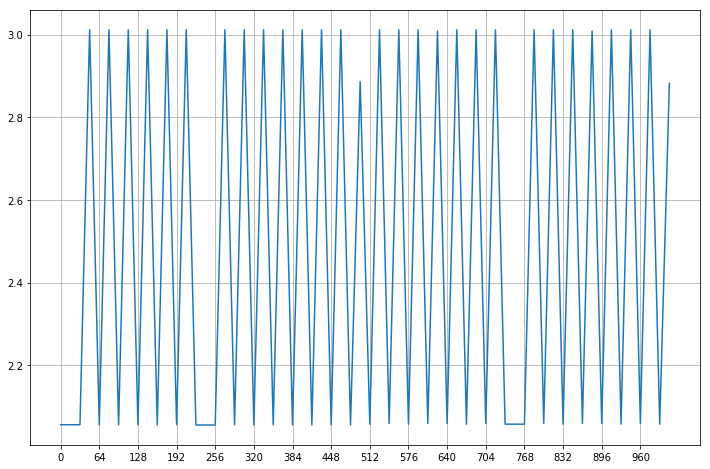

In [98]:
buf = numpy.ndarray((1000000, 1, 1))
buf_gpu = drv.mem_alloc(buf.nbytes)
drv.memcpy_htod(buf_gpu, buf)

buf2 = numpy.ndarray((1000000, 1, 1))
buf_gpu2 = drv.mem_alloc(buf.nbytes)
drv.memcpy_htod(buf_gpu2, buf2)

addresses = numpy.array([0 for i in range(32) ], dtype=numpy.int32)
addresses[0] = 15
addresses_gpu = drv.mem_alloc(addresses.nbytes)
drv.memcpy_htod(addresses_gpu, addresses)

def getBanks(addresses):
    banks = [ [] for a in addresses ]
    for a in addresses:
        if a not in banks[a % 16]:
            banks[a % 16].append(a)
    #for b in banks:
    #    print("{:1}".format(len(b)), end="")
    return max([len(b) for b in banks])


dwg = svgwrite.Drawing('test.svg', size=(400, 5500), profile='tiny')
gypos = 20


cycles = {}
for offset in range(0, 1024, 16):
    print(offset, end=" ")
    addresses = [1 + (i % 16) + (0 if i < 16 else offset) for i in range(32) ]
    load1 = getBanks(addresses[0:16])
    load2 = getBanks(addresses[16:32])
    print(load1+load2, end=" ")
    
    
    for i in range(4):
        L1CLs = []
        for a in addresses[i*8:(i+1)*8]:
            if a // 16 not in L1CLs:
                L1CLs.append(a // 16)
    
    
    
    addresses_gpu = drv.mem_alloc(len(addresses) * 4 )
    drv.memcpy_htod(addresses_gpu, numpy.array(addresses, dtype=numpy.int32))

    
    blockSize = 256

    grid = (1, 1, 1)
    block = (blockSize, 1, 1)

    times = []
    for i in range(5):
        start = drv.Event()
        end = drv.Event()
        cleaner_function.prepared_call((80, 1, 1), (256, 1, 1), buf_gpu, 100000)
        start.record()
        function.prepared_call(grid, block, buf_gpu, buf_gpu, addresses_gpu, 100000, 0)
        function.prepared_call(grid, block, buf_gpu, buf_gpu, addresses_gpu, 100000, 0)
        end.record()
        end.synchronize()
        dt = end.time_since(start) / 2
        times.append(dt)
                
    times.sort()
    dt = sum(times) / len(times)
    cycleString =  "{:6.3f} cyc".format( dt * 1.38e6 / 100000 / 2 / 8 / (blockSize / 32))
    print(cycleString)

    cycles[offset] = dt * 1.38e6 / 100000 / 2 / 8 / (blockSize / 32)
    
    bS = 7

    #dwg.add( dwg.text( cycleString, ( 0, gypos)))
    #for i in range(0, ((max(addresses) ) // 16 + 1 )  *16):
    #    xpos = (i  % 16) * (1.3*bS) + 5
    #    ypos = gypos + (i // 16) * (1.3 * bS) +5
    #    if i in addresses[0:8]:
    #        dwg.add(dwg.rect((xpos, ypos), (bS, bS), fill="yellow", stroke="gray"))
    #    elif i in addresses[8:16]:
    #        dwg.add(dwg.rect((xpos, ypos), (bS, bS), fill="red", stroke="gray"))
    #    elif i in addresses[16:24]:
    #        dwg.add(dwg.rect((xpos, ypos), (bS, bS), fill="green", stroke="gray"))
    #    elif i in addresses[24:]:
    #        dwg.add(dwg.rect((xpos, ypos), (bS, bS), fill="blue", stroke="gray"))
    #    else:
    #        dwg.add(dwg.rect((xpos, ypos), (bS, bS), fill="none", stroke="gray"))##

    
    gypos += ((max(addresses)) // 16 + 1) * (bS*1.3) + 30

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.plot(cycles.keys(), cycles.values())
plt.grid()
plt.xticks([x for x in range(0, max(cycles.keys()), 64)])
#plt.ylim((2.0, 3.2))
plt.show()
